In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pyproj import Proj
%run ../../src/downloading/utils.py

In [138]:
def load_mosaic_predictions(out_folder: str) -> np.ndarray:
    """
    Loads the .npy subtile files in an output folder and mosaics the overlapping predictions
    to return a single .npy file of tree cover for the 6x6 km tile
    Additionally, applies post-processing threshold rules and implements no-data flag of 255
    
        Parameters:
         out_folder (os.Path): location of the prediction .npy files 
    
        Returns:
         predictions (np.ndarray): 6 x 6 km tree cover data as a uint8 from 0-100 w/ 255 no-data flag
    """

    x_tiles = [int(x) for x in os.listdir(out_folder) if '.DS' not in x]
    max_x = np.max(x_tiles) + SIZE
    for x_tile in x_tiles:
        y_tiles = [int(y[:-4]) for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
        max_y = np.max(y_tiles) + SIZE
    predictions = np.full((max_x, max_y, len(x_tiles) * len(y_tiles)), np.nan, dtype = np.float32)
    mults = np.full((max_x, max_y, len(x_tiles) * len(y_tiles)), 0, dtype = np.float32)
    i = 0
    for x_tile in x_tiles:
        y_tiles = [int(y[:-4]) for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
        for y_tile in y_tiles:
            output_file = out_folder + str(x_tile) + "/" + str(y_tile) + ".npy"
            if os.path.exists(output_file):
                prediction = np.load(output_file)
                if np.sum(prediction) < SIZE*SIZE*255:
                    prediction = (prediction * 100).T.astype(np.float32)
                    predictions[x_tile: x_tile+SIZE, y_tile:y_tile + SIZE, i] = prediction
                    mults[x_tile: x_tile+SIZE, y_tile:y_tile + SIZE, i] = fspecial_gauss(SIZE, 40)
                i += 1

    predictions = predictions.astype(np.float32)
    predictions_range = np.nanmax(predictions, axis=-1) - np.nanmin(predictions, axis=-1)
    mean_certain_pred = np.nanmean(predictions[predictions_range < 50])
    mean_uncertain_pred = np.nanmean(predictions[predictions_range > 50])
    
    overpredict = True if (mean_uncertain_pred - mean_certain_pred) > 0 else False
    underpredict = True if not overpredict else False

    mults = mults #/ np.sum(mults, axis = -1)[..., np.newaxis]
    predictions[predictions > 100] = np.nan
    out = np.copy(predictions)
    out = np.sum(np.isnan(out), axis = (2))
    n_preds = predictions.shape[-1]
    #predictions = np.nansum(predictions * mults, axis = -1)
    predictions[out == n_preds] = np.nan
    predictions[np.isnan(predictions)] = 255.
    predictions = predictions.astype(np.uint8)
  
    return predictions, mults

In [139]:
def fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function

        Parameters:
         size (int): size of square guassian kernel
         sigma (float): diameter of the kernel
    
        Returns:
         g (np.ndarray): gaussian kernel from [0, 1]
    """
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g

In [140]:
SIZE = 208
x, mults = load_mosaic_predictions("../../project-monitoring/tiles/2451/962/processed/")

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater


<AxesSubplot:>

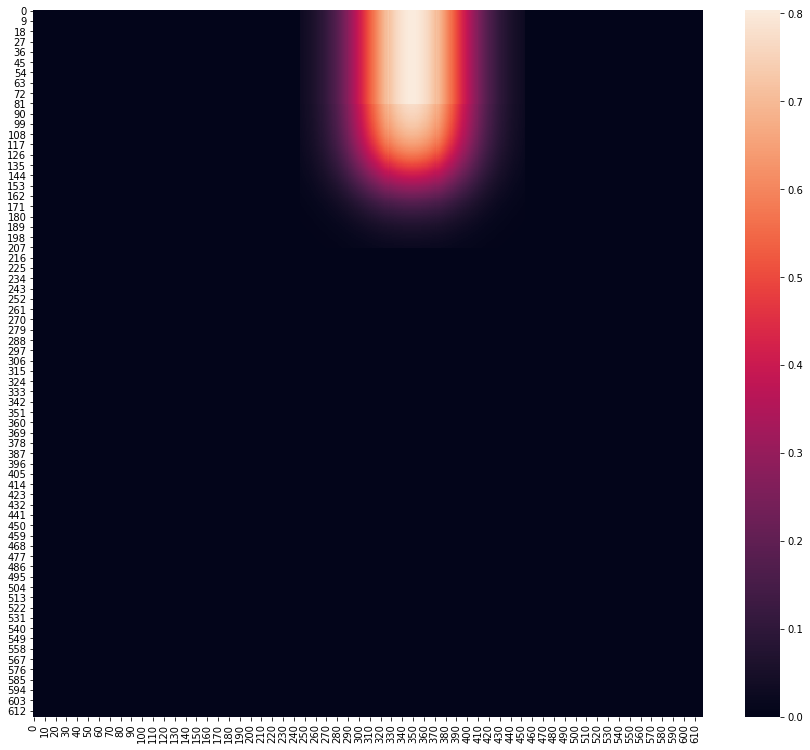

In [145]:
plt.figure(figsize=(15,13))
sns.heatmap((mults[..., 0] / np.sum(mults, axis = -1)))

In [5]:
from tqdm import tqdm_notebook, tnrange
files = [x for x in os.listdir("../../data/train-dates/") if '.npy' in x]


def select_dates(dates):
    """For imagery that was downloaded prior to capping the number 
       of monthly images to be 3, it is necessary to enforce that cap
       on the training / testing data.
       
       This function identifies the indices of the imagery to deletet
       such that there is a maximum of three images per month.
    
    """
    
    
    before = len(dates)
    selected_indices = np.arange(len(dates))
    begin = [-60, 0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
    end = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 390]
    indices_to_remove = []
    for x, y in zip(begin, end):
        indices_month = np.argwhere(np.logical_and(dates >= x, dates < y)).flatten()
        if len(indices_month) > 3:
            to_delete = np.empty((0,))
            if begin == -60:
                to_delete = indices_month[:-3]
            elif begin == 334:
                to_delete = indices_month[3:]
            elif len(indices_month) == 4:
                to_delete = indices_month[1]
            elif len(indices_month) == 5:
                to_delete = np.array([indices_month[1],
                                      indices_month[3]])
            elif len(indices_month) == 6:
                to_delete = np.array([indices_month[1],
                                      indices_month[3],
                                      indices_month[4]])
                
            to_delete = np.array(to_delete)
            if to_delete.size > 0:
                indices_to_remove.append(to_delete.flatten())
                
    if len(indices_to_remove) > 0:
        indices_to_remove = np.concatenate(indices_to_remove)
        after = before - len(indices_to_remove)
        return indices_to_remove
    
    else:
        return []
    

def subset_contiguous_sunny_dates(dates):
    begin = [-60, 0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
    end = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 390]
    n_per_month = []
    months_to_adjust = []
    indices_to_rm = []
    
    if len(dates) >= 20:
        for x, y in zip(begin, end):
            indices_month = np.argwhere(np.logical_and(
                dates >= x, dates < y)).flatten()
            n_per_month.append(len(indices_month))

        for x in range(11):
            three_m_sum = np.sum(n_per_month[x:x+3])
            if three_m_sum >= 7:
                months_to_adjust.append([x, x+1, x+2])

        months_to_adjust = [item for sublist in months_to_adjust for item in sublist]
        months_to_adjust = list(set(months_to_adjust))


        if len(months_to_adjust) > 0:
            for month in months_to_adjust:
                indices_month = np.argwhere(np.logical_and(
                    dates >= begin[month], dates < end[month])).flatten()
                if len(indices_month) == 3:
                    indices_to_rm.append(indices_month[1])
    return indices_to_rm


lengths = []
lengths_new = []
for file in tnrange(10000):
    #length = 0
    #length_original = 0
    dates = np.load("../../data/train-dates/" + files[file])
    
    init_rm = select_dates(dates)
    init_ln = len(dates) - len(init_rm)
    lengths.append(init_ln)
    
    indices_to_rm = subset_contiguous_sunny_dates(dates)
    lengths_new.append(init_ln - len(indices_to_rm))

In [6]:
np.mean(lengths_new)

20.6262

In [2]:
# Create a lookup that takes a bounding box training sample and identifies the name of the quad that it is in
# Use GDAL to open the quad and extract the bounding box
# For now, compare the data to the sentinel 2 data to see if it matches

In [182]:
!gdalwarp -s_srs EPSG:3857 -t_srs EPSG:4326 -r near -of GTiff \
        /Users/john.brandt/Documents/GitHub/restoration-mapper/data/makueni2.tif /Users/john.brandt/Documents/GitHub/restoration-mapper/data/makueni3.tif 

Using band 5 of source image as alpha.
Creating output file that is 4097P x 4095L.
Processing /Users/john.brandt/Documents/GitHub/restoration-mapper/data/makueni2.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [3]:
data = gdal.Open('../../data/makueni3.tif')
geoTransform = data.GetGeoTransform()
minx = geoTransform[0]
maxy = geoTransform[3]
maxx = minx + geoTransform[1] * data.RasterXSize
miny = maxy + geoTransform[5] * data.RasterYSize
print(minx, miny, maxx, maxy)

37.61718749483162 -1.757531260077198 37.79297430367648 -1.5818302636847892


In [8]:
df = pd.read_csv("../../data/train-csv/kenya-planet.csv")
for column in ['IMAGERY_TITLE', 'STACKINGPROFILEDG', 'PL_PLOTID', 'IMAGERYYEARDG',
              'IMAGERYMONTHPLANET', 'IMAGERYYEARPLANET']:
    if column in df.columns:
        df = df.drop(column, axis = 1)
df = df.dropna(axis = 0)
plot_ids = sorted(df['PLOT_ID'].unique())

In [14]:
def within_tif(bbox, minx = minx, miny = miny, maxx = maxx, maxy = maxy):
    within_x = np.logical_and((bbox[1][0] > minx), (bbox[0][0] < maxx))
    within_y = np.logical_and((bbox[0][1] > miny), (bbox[1][1] < maxy))
    within = np.logical_and(within_x, within_y)
    return within

In [4]:
def calc_bbox(plot_id, df):
    """ Calculates the corners of a bounding box from an input
        pandas dataframe as output by Collect Earth Online

        Parameters:
         plot_id (int): plot_id of associated plot
         df (pandas.DataFrame): dataframe of associated CEO survey
    
        Returns:
         bounding_box (list): [(min(x), min(y)),
                              (max(x), max_y))]
    """
    subs = df[df['PLOT_ID'] == plot_id]
    # TOP, LEFT, BOTTOM, RIGHT
    # (min x, min y), (max x, max y)
    return [(min(subs['LON']), min(subs['LAT'])),
            (max(subs['LON']), max(subs['LAT']))]


def bounding_box(points, expansion = 160):
    """ Calculates the corners of a bounding box with an
        input expansion in meters from a given bounding_box
        
        Subcalls:
         calculate_epsg, convertCoords

        Parameters:
         points (list): output of calc_bbox
         expansion (float): number of meters to expand or shrink the
                            points edges to be
    
        Returns:
         bl (tuple): x, y of bottom left corner with edges of expansion meters
         tr (tuple): x, y of top right corner with edges of expansion meters
    """
    bl = list(points[0])
    tr = list(points[1])
    inproj = Proj('epsg:4326')
    outproj_code = calculate_epsg(bl)
    outproj = Proj('epsg:' + str(outproj_code))
    
    bl_utm =  transform(inproj, outproj, bl[1], bl[0])
    tr_utm =  transform(inproj, outproj, tr[1], tr[0])

    distance1 = tr_utm[0] - bl_utm[0]
    distance2 = tr_utm[1] - bl_utm[1]
    expansion1 = (expansion - distance1)/2
    expansion2 = (expansion - distance2)/2
        
    bl_utm = [bl_utm[0] - expansion1, bl_utm[1] - expansion2]
    tr_utm = [tr_utm[0] + expansion1, tr_utm[1] + expansion2]
    bl =  transform(outproj, inproj, bl_utm[0], bl_utm[1])
    tr =  transform(outproj, inproj, tr_utm[0], tr_utm[1])
    bl = (bl[1], bl[0])
    tr = (tr[1], tr[0])

    zone = str(outproj_code)[3:]
    zone = zone[1:] if zone[0] == "0" else zone
    direction = 'N' if tr[1] >= 0 else 'S'
    utm_epsg = "UTM_" + zone + direction
    return (bl, tr)

def reconstruct_images(plot_id):
    '''Takes a plot ID and subsets the input pd.DataFrame to that plot ID
       returns a (14, 14) array-like list with binary labels
       
        Parameters:
          batch_ids (list):
          batch_size (int):
          
         Returns:
          x_batch (arr):
          y_batch (arr):
    '''
    subs = df[df['PLOT_ID'] == plot_id]
    rows = []
    lats = reversed(sorted(subs['LAT'].unique()))
    for i, val in enumerate(lats):
        subs_lat = subs[subs['LAT'] == val]
        subs_lat = subs_lat.sort_values('LON', axis = 0)
        rows.append(list(subs_lat['TREE']))
    return rows

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 138303007
3442.0
1 138303008
3337.0
2 138303009
3530.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 138303010
3327.0
4 138303011
3861.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 138303012
3114.0
6 138303014
4174.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 138303015
3619.0
8 138303016
3234.0


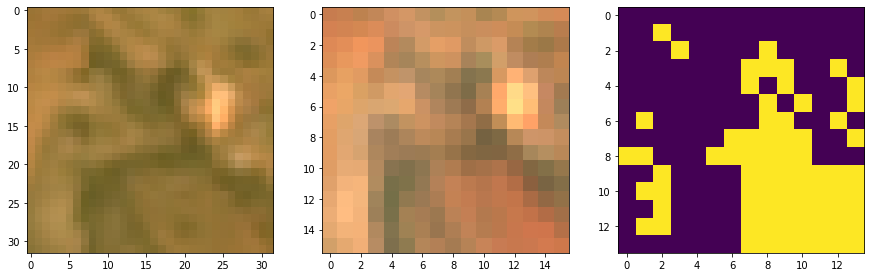

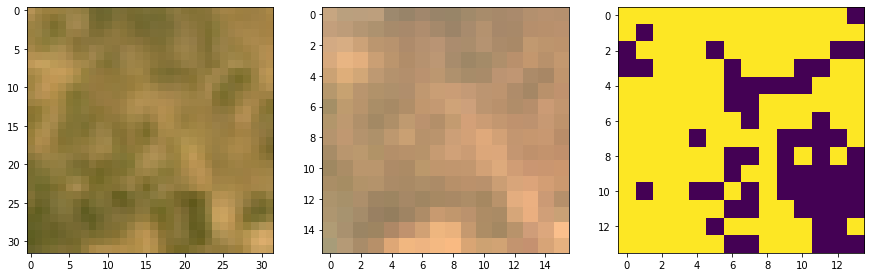

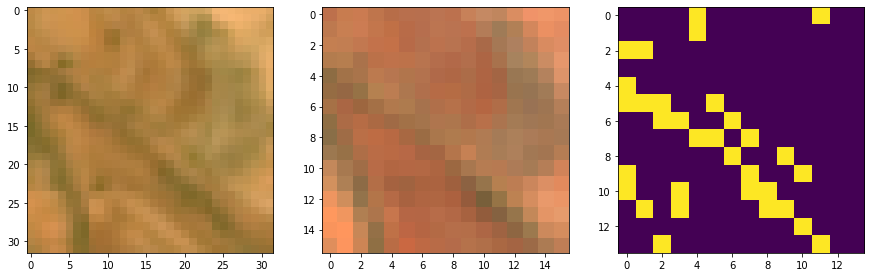

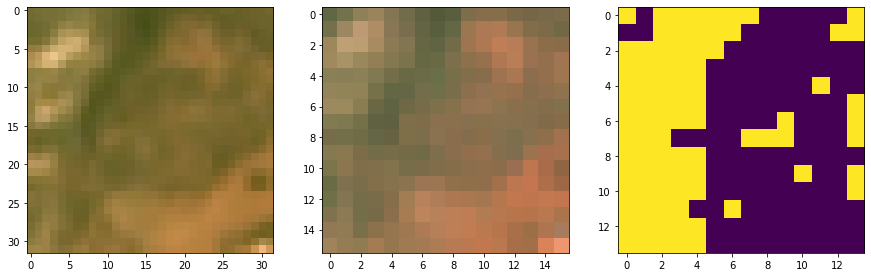

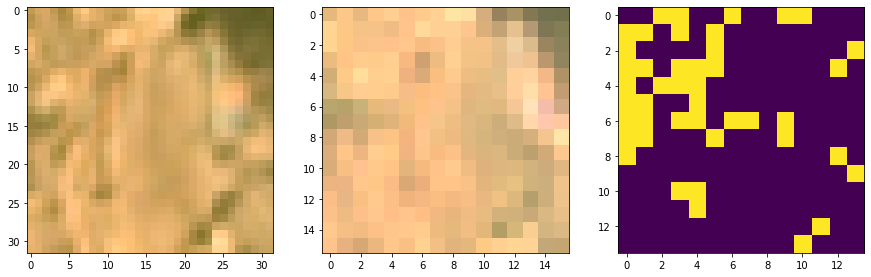

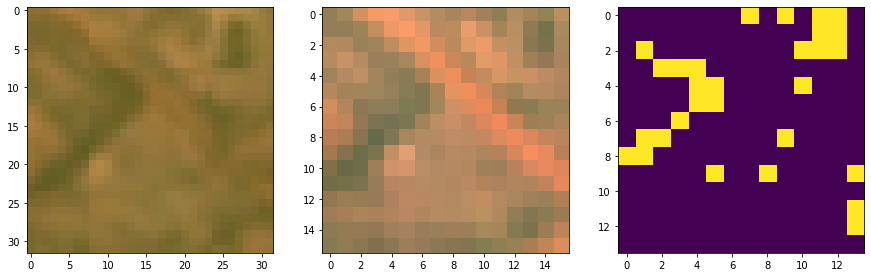

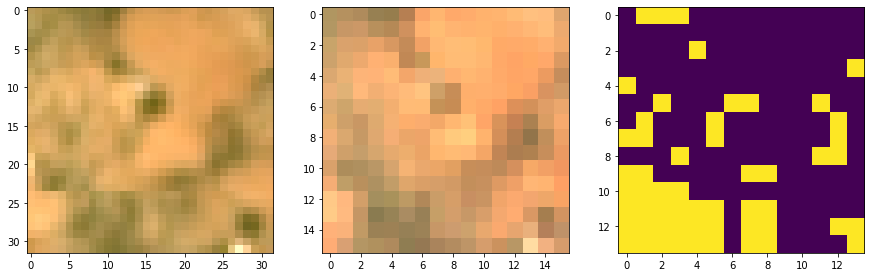

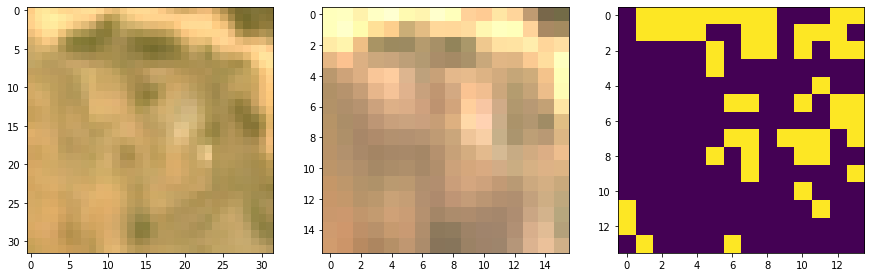

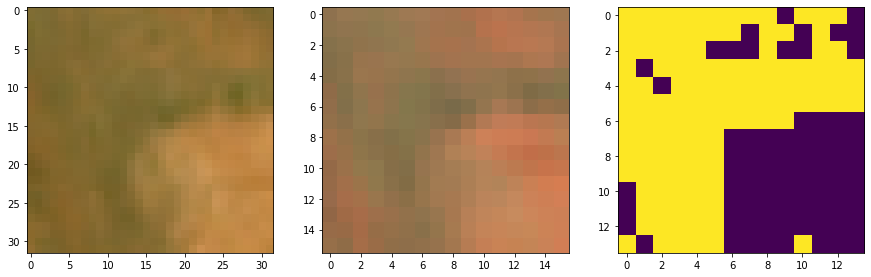

In [17]:
for i, val in enumerate(plot_ids):
    bbx = calc_bbox(val, df = df)
    bbx = bounding_box(bbx, expansion = 160)
    within = within_tif(bbx)
    if within:
        print(i, val)
        ds = gdal.Translate('', '../../data/makueni3.tif', format = 'MEM',
                    projWin = [bbx[0][0], bbx[1][1], 
                               bbx[1][0], bbx[0][1]])
        planet = np.array(ds.ReadAsArray())
        planet = np.swapaxes(planet, 0, 2)
        planet = np.swapaxes(planet, 0, 1)
        planet = planet[..., :-1]
        planet = np.float32(planet)
        planet = resize(planet, (32, 32, planet.shape[-1]), order = 0)
        np.save(f"../../data/test-planet/{str(val)}.npy", planet)
        
        bgr = planet[..., :3]
        print(np.max(planet))
        bgr = bgr / 1600
        red = np.copy(bgr[..., 2])
        blue = np.copy(bgr[..., 0])
        bgr[..., 0] = red
        bgr[..., 2] = blue
        
        
        x = np.load(f"../../data/test-s2/{plot_ids[i]}.npy")
        x = x[..., :3]
        blue = np.copy(x[..., 0])
        red = np.copy(x[..., 2])
        x[..., 0] = red
        x[..., 2] = blue

        y = reconstruct_images(plot_ids[i])
        y = np.array(y)*255
        images = [bgr, x[12] * 6, y]
        plt.figure(figsize=(15,10))
        columns = 3
        for i, image in enumerate(images):
            plt.subplot(len(images) / columns + 1, columns, i + 1)
            plt.imshow(image)
            

# Generate train data

In [9]:
data_y = np.empty((len(plot_ids), 14, 14))
data_x = np.empty((len(plot_ids), 24, 16, 16, 17))
data_planet = np.empty((len(plot_ids), 32, 32, 4))
for i, val in enumerate(plot_ids):
    y = reconstruct_images(val)
    x = np.load(f"../../data/train-s2/{str(val)}.npy")
    x_s1 = np.load(f"../../data/train-s1/{str(val)}.npy")
    x = np.concatenate([x, x_s1], axis = -1)
    planet = np.load(f"../../data/train-planet/{str(val)}.npy")
    data_y[i] = y
    data_x[i] = x
    data_planet[i] = planet

In [12]:
np.save("data/train_y.npy", data_y)
np.save("data/train_x.npy", data_x)
np.save("data/train_planet.npy", data_planet)
        